<u><b>This notebook contains tools to train a CNN model</u></b>

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys,re
from PIL import Image

import pandas as pd

import torch
from preprocessing import *
from experimental_neural_nets import Conv_test, Road_data, set_seed
from road_correction import process_roads, f1_loss_numpy
from mask_to_submission import *

### <b> Loading train datasets</b>

In [2]:
def load_image(infilename):
    """ Loads an image from a file into a NumPy array
    """
    data = mpimg.imread(infilename)
    return data


root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
imgs,gt_imgs = flip_train_data(imgs,gt_imgs)


Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png
Number of images:  400
Number of groundtruth images:  400
Number of images after flipping:  1600
Number of groundtruth images after flipping:  1600


Image size = 400,400


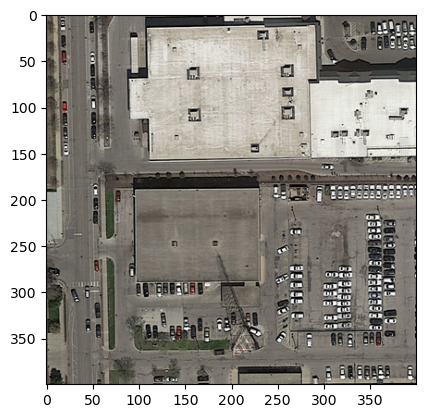

In [ ]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))
plt.imshow(imgs[240], cmap="Greys_r")
plt.show()

### <b>Parameters for search</b>

In [4]:
list_param_dict = [
    {'out_channels': 8, 'kernel_size': 15, 'stride': 1, 'padding': 7},
    {'out_channels': 16, 'kernel_size': 7, 'stride': 1, 'padding': 3},
    {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2},
    {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ]
skip_list = None
skip_targets = None

In [5]:
set_seed() #setting seed for reproducibility
model = Conv_test(in_channels=3,
                  list_conv_param=list_param_dict,
                  skip_list_C=skip_list,
                  skip_targets_C=skip_targets)

### <b>CNN Training</b>

In [6]:
import torch
from torch.utils.data import DataLoader


use_saved_model = True  # Set to True to load the model from a .pth file

num_epochs = 20
model_path = "CNN_model.pth"

dataset = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

if use_saved_model:
    # Load the model from the .pth file
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
else:
    # Train the model
    for epoch in range(num_epochs):
        model.train()  
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Epoch 1/20, Loss: 0.6987
Epoch 2/20, Loss: 0.6960
Epoch 3/20, Loss: 0.6868
Epoch 4/20, Loss: 0.6844
Epoch 5/20, Loss: 0.6923
Epoch 6/20, Loss: 0.6881
Epoch 7/20, Loss: 0.6905
Epoch 8/20, Loss: 0.6848
Epoch 9/20, Loss: 0.6890
Epoch 10/20, Loss: 0.6907
Epoch 11/20, Loss: 0.6886
Epoch 12/20, Loss: 0.6842
Epoch 13/20, Loss: 0.6845
Epoch 14/20, Loss: 0.6814
Epoch 15/20, Loss: 0.6788
Epoch 16/20, Loss: 0.6863
Epoch 17/20, Loss: 0.6859
Epoch 18/20, Loss: 0.6787
Epoch 19/20, Loss: 0.6811
Epoch 20/20, Loss: 0.6744
Model saved to CNN_model.pth


### <b>Visualisation over training</b>

/var/folders/7_/thb0nb1n68j5t838_czz_hh00000gn/T/ipykernel_2931/1502627169.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  image = torch.tensor(imgs[0:10]).permute(0,3, 1, 2)


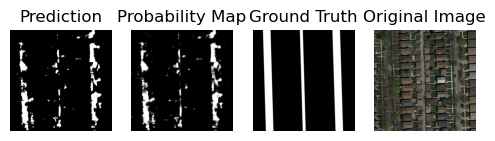

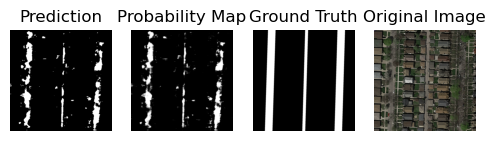

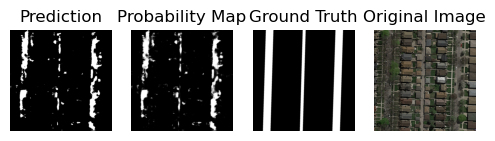

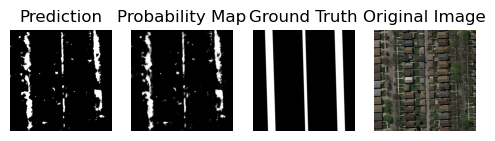

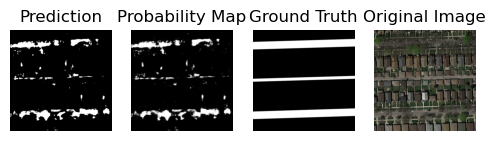

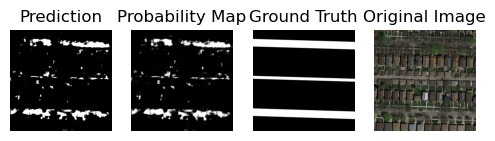

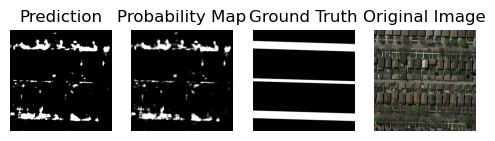

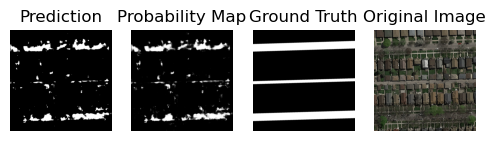

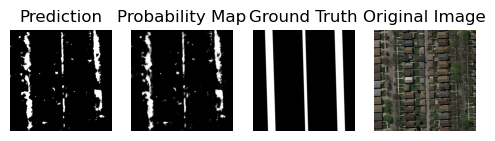

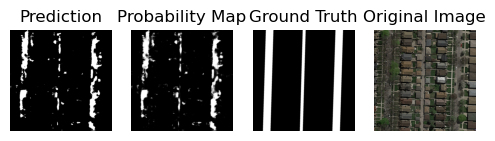

In [7]:
image = torch.tensor(imgs[0:10]).permute(0,3, 1, 2)
pred = model(image)
pred_np = pred.detach().cpu().numpy()

threshold = 0.5
num_images = pred_np.shape[0]
for i in range(len(pred_np)):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
    pred_mask = (pred_np[i] > threshold).astype(np.uint8)  
    pred_image = Image.fromarray(pred_mask * 255)

    axes[0].imshow(pred_image, cmap='gray')
    axes[0].set_title("Prediction")

    axes[1].imshow(pred_np[i], cmap='gray')
    axes[1].set_title("Probability Map")
    
    axes[2].imshow(gt_imgs[i], cmap='gray')
    axes[2].set_title("Ground Truth")

    img_np = image[i].permute(1, 2, 0).cpu().numpy() 

    axes[3].imshow(img_np)
    axes[3].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    axes[3].axis("off")

    plt.show()

### <b> Loading test dataset </b>

In [8]:
test_dir = "data/test_set_images/"

def natural_sort_key(s):
    # Extract numbers from the string for sorting
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

test_folders = sorted(
    [folder for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))],
    key=natural_sort_key
)

n_test = len(test_folders)
print("Loading " + str(n_test) + " images")

test= []
for folder in test_folders:
    folder_path = os.path.join(test_dir, folder)
    
    image_files = sorted(
        [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))],
        key=natural_sort_key
    )
    
    if image_files:
        image_path = os.path.join(folder_path, image_files[0])
        test.append(load_image(image_path))

Loading 50 images


### <b> Prediction over test set and creation of submission file </b>

In [9]:
test_IM = np.array(test)
image = torch.tensor(test_IM).permute(0,3, 1, 2)
pred = model(image)
pred_np = pred.detach().cpu().numpy()

In [10]:
threshold = 0.5

def getting_sub (prediction):

    output_dir = 'predictions_KNN_final'
    os.makedirs(output_dir, exist_ok=True)

    pred_filenames = []
    for i in range(len(prediction)):
        pred_mask = (prediction[i] > threshold).astype(np.uint8) 
        pred_image = Image.fromarray(pred_mask * 255)  
        filename = os.path.join(output_dir, f"{i+1:03d}.png")
        filename = os.path.join(output_dir, f"prediction_{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    submission_filename = 'CNN_final.csv'
    masks_to_submission(submission_filename, *pred_filenames)
    

getting_sub(pred_np)